# Image Captioning - Feature Extraction

## Introduction

In this notebook, we'll extract meaningful visual features from our images using pre-trained Convolutional Neural Networks (CNNs). This is a crucial step in our image captioning pipeline for several reasons:

1. **Transfer Learning**: Rather than training a vision model from scratch (which would require massive computational resources and data), we leverage pre-trained models that have already learned rich visual representations from millions of images.

2. **Computational Efficiency**: By pre-computing image features just once and saving them to disk, we can significantly speed up the training of our captioning model, as we won't need to pass images through the CNN during each training epoch.

3. **Architectural Decoupling**: Separating feature extraction from caption generation allows us to experiment with different language models without re-processing the images.

We'll extract features using several different CNN architectures and compare their characteristics in terms of:
- Feature dimensionality
- Extraction speed
- Memory requirements
- Feature distribution properties

This comparison will help us make an informed decision about which architecture to use for our image captioning system.

In [9]:
import os
import sys
from typing import Dict, List, Tuple
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import h5py
import seaborn as sns

# Add project root to path to allow importing from other modules
sys.path.append('..')

# Import project modules
from models.encoder import EncoderCNN
from utils.vocabulary import Vocabulary

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Understanding Transfer Learning for Image Feature Extraction

Before diving into the code, let's understand the concept of transfer learning and why it's so valuable for our task.

### What is Transfer Learning?

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. For computer vision, this typically means using CNNs pre-trained on large image datasets like ImageNet.

### Why Use Pre-trained Models?

1. **Knowledge Transfer**: Early layers of CNNs learn general features (edges, textures) while deeper layers learn more task-specific features. The general features are useful across many vision tasks.

2. **Efficiency**: Training a CNN from scratch requires massive computational resources and large labeled datasets.

3. **Performance**: Models initialized with pre-trained weights often achieve better performance than those trained from scratch, especially with limited data.

### How We'll Use Transfer Learning

For our image captioning task, we'll:

1. Take a CNN pre-trained on ImageNet (e.g., ResNet, MobileNet or InceptionV3)
2. Remove the final classification layer
3. Use the remaining network as a fixed feature extractor
4. Extract and save features for all images in our dataset
5. These features will become the input to our caption generator (RNN/LSTM)

Let's visualize this process:

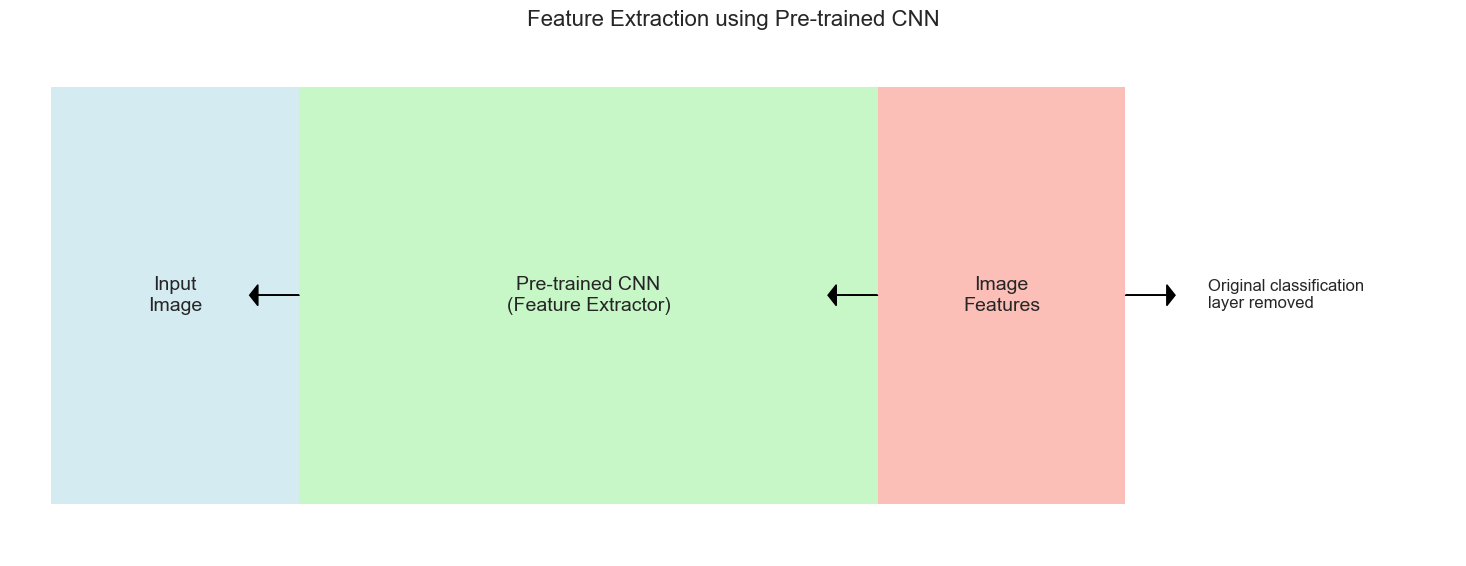

In [3]:
from matplotlib.patches import Rectangle

# Create a visualization of the transfer learning process
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Create boxes for the visualization
ax.add_patch(Rectangle((0, 0), 3, 4, facecolor='lightblue', alpha=0.5))
ax.add_patch(Rectangle((3, 0), 7, 4, facecolor='lightgreen', alpha=0.5))
ax.add_patch(Rectangle((10, 0), 3, 4, facecolor='salmon', alpha=0.5))

# Add labels
ax.text(1.5, 2, 'Input\nImage', ha='center', va='center', fontsize=14)
ax.text(6.5, 2, 'Pre-trained CNN\n(Feature Extractor)', ha='center', va='center', fontsize=14)
ax.text(11.5, 2, 'Image\nFeatures', ha='center', va='center', fontsize=14)

# Add arrows
ax.arrow(3, 2, -0.5, 0, head_width=0.2, head_length=0.1, fc='black', ec='black')
ax.arrow(10, 2, -0.5, 0, head_width=0.2, head_length=0.1, fc='black', ec='black')
ax.arrow(13, 2, 0.5, 0, head_width=0.2, head_length=0.1, fc='black', ec='black')

# Text for removed classification layer
ax.text(14, 2, 'Original classification\nlayer removed', ha='left', va='center', fontsize=12)

# Set axis limits and remove ticks
ax.set_xlim(-0.5, 17)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Feature Extraction using Pre-trained CNN', fontsize=16)

# Remove axis borders
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

## 2. Creating a Dataset for Feature Extraction

Now, let's implement a PyTorch `Dataset` class that will load and preprocess our images for feature extraction. This class will:

1. Load images from disk
2. Apply necessary transformations (resizing, normalization, etc.)
3. Return the preprocessed images along with their filenames

The transformations we apply are crucial and must match those used during training of the pre-trained models to ensure the extracted features are meaningful.

In [4]:
class ImageDataset(Dataset):
    """Dataset for loading images for feature extraction."""
    
    def __init__(self, images_dir, image_list, transform=None):
        """
        Initialize the dataset.
        
        Args:
            images_dir (str): Directory containing the images
            image_list (list): List of image filenames
            transform (callable, optional): Transform to apply to the images
        """
        self.images_dir = images_dir
        self.image_list = image_list
        
        # Define default transform if none is provided
        # These transformations match those used during training of the pre-trained models
        if transform is None:
            self.transform = transforms.Compose([
                # Resize to 256x256 while maintaining aspect ratio
                transforms.Resize(256),
                # Center crop to 224x224 (standard input size for many CNNs)
                transforms.CenterCrop(224),
                # Convert PIL image to PyTorch tensor (0-1 range)
                transforms.ToTensor(),
                # Normalize using ImageNet mean and std
                # This is crucial as the pre-trained models expect this normalization
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],  # ImageNet mean
                    std=[0.229, 0.224, 0.225]    # ImageNet std
                )
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.image_list)
    
    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        # TODO: Implement the method to get a sample from the dataset
        # 1. Get the image filename at the given index
        # 2. Construct the full path to the image 
        # 3. Load the image using PIL and convert to RGB format
        # 4. Apply the transformations to the image
        # 5. Return the transformed image and its filename
        img_name = self.image_list[idx]
        img_dir = os.path.join(self.images_dir, img_name)
        image = Image.open(img_dir).convert('RGB')
        image = self.transform(image)
        
        return image, img_name

In [13]:
a =  os.listdir('../data/flickr8k/processed/images')[10]
dd = os.path.join('..', 'data', 'flickr8k', 'processed', 'images', a)
img = Image.open(dd)

### Explanation of the Image Transformations

The transformations we apply in our dataset are critical for ensuring compatibility with pre-trained models:

1. **Resize(256)**: First, we resize the image to have a smaller dimension of 256 pixels while maintaining the aspect ratio. This standardizes the image size while preserving the content.

2. **CenterCrop(224)**: We then take a center crop of 224×224 pixels. This is the standard input size for many CNN architectures trained on ImageNet. The center crop helps focus on the main subject of the image.

3. **ToTensor()**: This converts the PIL image (with pixel values 0-255) to a PyTorch tensor with values normalized to the range [0.0, 1.0].

4. **Normalize()**: Finally, we normalize each color channel using the mean and standard deviation of the ImageNet dataset. This ensures the input distribution matches what the pre-trained network expects.

Let's look at how these transformations affect an example image:

Found 8092 unique images in the captions file


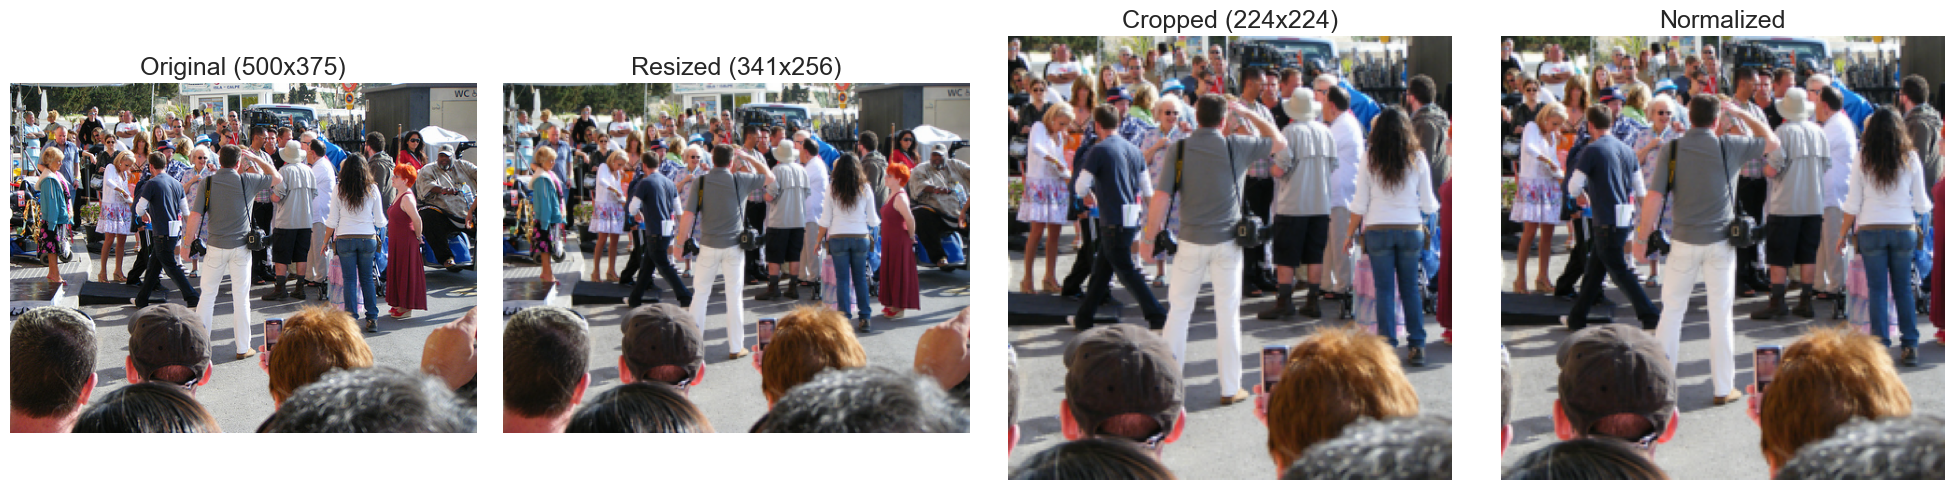

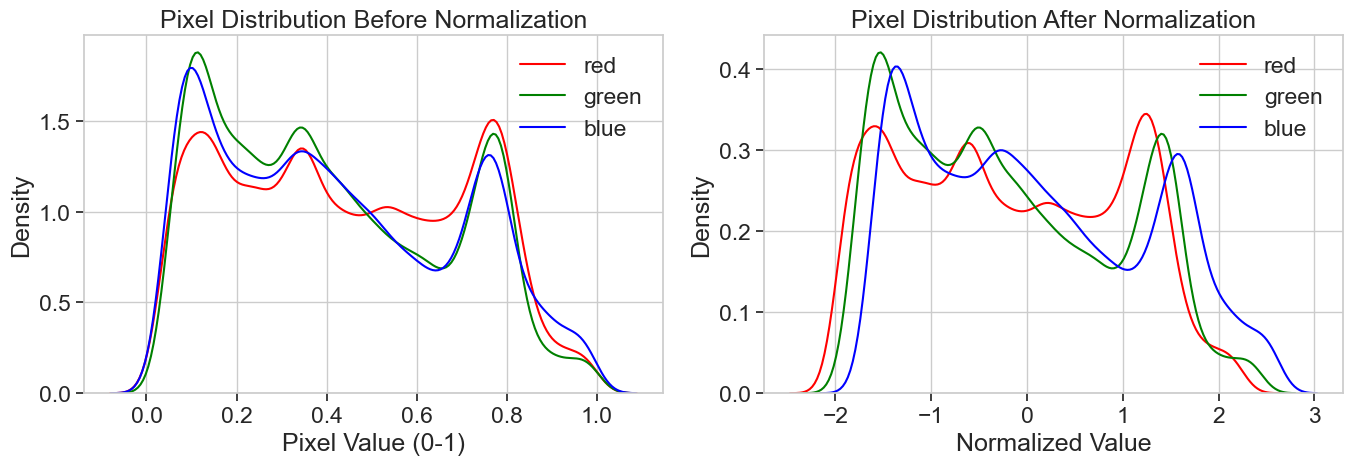

In [5]:
# Define the data directory and paths
data_dir = '../data/flickr8k/processed'
images_dir = os.path.join(data_dir, 'images')
features_dir = os.path.join(data_dir, 'features')
os.makedirs(features_dir, exist_ok=True)

# Load captions file to get list of image names
captions_path = os.path.join(data_dir, 'captions.csv')
if os.path.exists(captions_path):
    captions_df = pd.read_csv(captions_path)
    # Get unique image names
    image_names = captions_df['image'].unique().tolist()
    print(f"Found {len(image_names)} unique images in the captions file")
    
    # Display a sample image with transformations
    if len(image_names) > 0:
        # Select a random image
        import random
        sample_img_name = random.choice(image_names)
        img_path = os.path.join(images_dir, sample_img_name)
        
        if os.path.exists(img_path):
            # Load the original image
            original_img = Image.open(img_path).convert('RGB')
            
            # Create individual transformations for visualization
            resize_transform = transforms.Resize(256)
            crop_transform = transforms.CenterCrop(224)
            tensor_transform = transforms.ToTensor()
            normalize_transform = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            
            # Apply transformations step by step
            resized_img = resize_transform(original_img.copy())
            cropped_img = crop_transform(resized_img)
            tensor_img = tensor_transform(cropped_img)
            normalized_img = normalize_transform(tensor_img)
            
            # Convert tensors back to PIL images for display
            tensor_img_display = tensor_img.permute(1, 2, 0).numpy()
            
            # For normalized image, we need to denormalize for display
            normalized_img_display = normalized_img.permute(1, 2, 0).numpy()
            normalized_img_display = normalized_img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            normalized_img_display = np.clip(normalized_img_display, 0, 1)
            
            # Display the transformation steps
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            axes[0].imshow(original_img)
            axes[0].set_title(f'Original ({original_img.size[0]}x{original_img.size[1]})')
            axes[0].axis('off')
            
            axes[1].imshow(resized_img)
            axes[1].set_title(f'Resized ({resized_img.size[0]}x{resized_img.size[1]})')
            axes[1].axis('off')
            
            axes[2].imshow(cropped_img)
            axes[2].set_title(f'Cropped ({cropped_img.size[0]}x{cropped_img.size[1]})')
            axes[2].axis('off')
            
            axes[3].imshow(normalized_img_display)
            axes[3].set_title('Normalized')
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Show pixel value distributions before and after normalization
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Before normalization (values between 0 and 1)
            for i, color in enumerate(['red', 'green', 'blue']):
                sns.kdeplot(tensor_img[i].numpy().flatten(), ax=axes[0], label=color, color=color)
            axes[0].set_title('Pixel Distribution Before Normalization')
            axes[0].set_xlabel('Pixel Value (0-1)')
            axes[0].set_ylabel('Density')
            axes[0].legend()
            
            # After normalization (values generally between -2 and 2)
            for i, color in enumerate(['red', 'green', 'blue']):
                sns.kdeplot(normalized_img[i].numpy().flatten(), ax=axes[1], label=color, color=color)
            axes[1].set_title('Pixel Distribution After Normalization')
            axes[1].set_xlabel('Normalized Value')
            axes[1].set_ylabel('Density')
            axes[1].legend()
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Sample image not found at path: {img_path}")
else:
    print(f"Captions file not found at path: {captions_path}")
    # Create a small sample set for demonstration
    image_names = [f"sample_image_{i}.jpg" for i in range(10)]
    print(f"Created {len(image_names)} sample image names for demonstration")

## 3. Feature Extraction Function

Now, we'll define a function to extract features from images using a pre-trained CNN model. This function will:

1. Process images in batches through the model
2. Extract features from the penultimate layer
3. Store the features in an HDF5 file for efficient storage and retrieval
4. Track and report time performance

In [10]:
def extract_features(dataloader: DataLoader, model: nn.Module, output_file: str, device: str='cuda') -> dict:
    """
    Extract features from images using a CNN model.
    
    Args:
        dataloader (DataLoader): DataLoader for the images
        model (nn.Module): CNN model for feature extraction
        output_file (str): Path to save the features
        device (str): Device to use ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary of extracted features
    """
    features: Dict[str, torch.Tensor] = dict()
    # TODO: Implement feature extraction
    # 1. Move model to device and set to evaluation mode
    # 2. Create a dictionary to store features
    # 3. Track timing for performance analysis
    # 4. Process images in batches using torch.no_grad()
    # 5. Extract features using the model
    # 6. Store features with image names as keys
    # 7. Calculate and print timing statistics
    # 8. Save features to HDF5 file
    
    model.to(device)
    model.eval()
    
    start = time.perf_counter() # Start time
    
    # Feature Extraction
    with torch.no_grad():
        for imgs, img_names in tqdm(dataloader, desc='Extracting Features'):
            imgs = imgs.to(device)
            outputs = model(imgs)
            
            for img_name, feature in zip(img_names, outputs):
                features[img_name] = feature.cpu()
                
    
    torch.cuda.synchronize() if device == 'cuda' else None 
    end = time.perf_counter() # End time
    
    print(f"Feature extraction completed in {end - start:.2f} seconds.")
    
    # Save to HDF5
    with h5py.File(output_file, 'w') as h5f:
        for key, feat in features.items():
            h5f.create_dataset(key, data=feat.numpy())
            
            
    return features

## 4. Create Dataset and DataLoader

Now, let's create our dataset and dataloader for feature extraction. The dataloader will efficiently batch the images for processing.

In [6]:
# Create dataset and dataloader
image_dataset = ImageDataset(images_dir, image_names)

# Create data loader with batching and parallel loading
dataloader = DataLoader(
    image_dataset,
    batch_size=32,               # Process 32 images at once
    shuffle=False,               # No need to shuffle for feature extraction
    num_workers=4,               # Use 4 worker threads for data loading
    pin_memory=True              # Pin tensors in memory for faster GPU transfer
)

print(f"Created dataloader with {len(dataloader)} batches")

Created dataloader with 253 batches


## 5. Define CNN Models for Feature Extraction

We'll now define several CNN architectures to use for feature extraction. We'll compare:

1. **ResNet18**: A relatively lightweight model (11M parameters) with 512-dimensional features
2. **ResNet50**: A deeper model (25M parameters) with 2048-dimensional features
3. **MobileNetV2**: A mobile-optimized model (3.5M parameters) with 1280-dimensional features

Each model offers different trade-offs between computational efficiency and feature quality.

In [11]:
# Define the CNN models to use for feature extraction
cnn_models = {
    'resnet18': {
        'model': EncoderCNN(model_name='resnet18', embed_size=256),
        'output_file': os.path.join(features_dir, 'resnet18_features.h5'),
        'feature_size': 512,
        'params': 11.7,  # Millions of parameters
        'description': 'Lightweight model with good performance/speed tradeoff'
    },
    'resnet50': {
        'model': EncoderCNN(model_name='resnet50', embed_size=256),
        'output_file': os.path.join(features_dir, 'resnet50_features.h5'),
        'feature_size': 2048,
        'params': 25.6,
        'description': 'Deeper model with higher-dimensional features'
    },
    'mobilenet_v2': {
        'model': EncoderCNN(model_name='mobilenet_v2', embed_size=256),
        'output_file': os.path.join(features_dir, 'mobilenet_v2_features.h5'),
        'feature_size': 1280,
        'params': 3.5,
        'description': 'Efficient model designed for mobile devices'
    }
}

# Display model information in a table
model_info = []
for name, config in cnn_models.items():
    model_info.append({
        'Model': name,
        'Feature Dim': config['feature_size'],
        'Parameters (M)': config['params'],
        'Description': config['description']
    })

pd.DataFrame(model_info).set_index('Model')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Amirhossein/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:43<00:00, 1.09MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Amirhossein/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [01:31<00:00, 1.13MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Amirhossein/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:12<00:00, 1.11MB/s]


,Feature Dim,Parameters (M),Description
Model,,,
resnet18,512,11.7,Lightweight model with good performance/speed ...
resnet50,2048,25.6,Deeper model with higher-dimensional features
mobilenet_v2,1280,3.5,Efficient model designed for mobile devices


## 6. Extract Features with Each Model

Now we'll extract features using each of our defined CNN models. This process might take some time, especially for larger models and datasets.

If you're running on a system with limited GPU memory, you might want to comment out the larger models (ResNet50) and focus on the smaller ones first.

In [ ]:
# Extract features for each model
results = {}

for name, config in cnn_models.items():
    print(f"\n{'='*50}")
    print(f"Extracting features using {name}...")
    print(f"{'='*50}")
    
    # Skip if features already exist
    if os.path.exists(config['output_file']):
        print(f"Features for {name} already exist at {config['output_file']}")
        print(f"Size: {os.path.getsize(config['output_file']) / (1024 * 1024):.2f} MB")
        
        # Load a sample of features to analyze
        with h5py.File(config['output_file'], 'r') as h5f:
            # Get a list of all dataset names (image filenames)
            image_names = list(h5f.keys())
            # Get the shape of the first dataset
            feature_shape = h5f[image_names[0]].shape
            
            results[name] = {
                'num_features': len(image_names),
                'feature_shape': feature_shape,
                'output_file': config['output_file']
            }
        
        print(f"Loaded info for {len(image_names)} features with shape {feature_shape}")
        continue
    
    # Extract features
    features = extract_features(
        dataloader=dataloader,
        model=config['model'],
        output_file=config['output_file'],
        device=device
    )
    
    # Store results
    results[name] = {
        'num_features': len(features),
        'feature_shape': next(iter(features.values())).shape,
        'output_file': config['output_file']
    }

## 7. Compare Model Performance

Let's summarize and compare the performance of each model in terms of feature dimensionality, storage requirements, and processing time.

In [ ]:
# Display results summary
summary = []
for name, result in results.items():
    file_size_mb = os.path.getsize(result['output_file']) / (1024 * 1024)
    file_size_per_image_kb = file_size_mb * 1024 / result['num_features']
    
    summary.append({
        'Model': name,
        'Feature Dimension': result['feature_shape'],
        'Number of Images': result['num_features'],
        'Total Storage (MB)': file_size_mb,
        'Storage per Image (KB)': file_size_per_image_kb
    })

# Create a summary dataframe
summary_df = pd.DataFrame(summary).set_index('Model')

# Format the numeric columns
summary_df['Total Storage (MB)'] = summary_df['Total Storage (MB)'].map('{:.2f}'.format)
summary_df['Storage per Image (KB)'] = summary_df['Storage per Image (KB)'].map('{:.2f}'.format)

# Display the summary
summary_df

## 8. Analyze Feature Properties

Now, let's analyze the properties of the extracted features. We'll load a sample of features from each model and examine their distributions, principal components, and similarities.

In [ ]:
# Load features for analysis
def load_features(feature_file, max_samples=100):
    """Load a sample of features from an H5 file."""
    # TODO: Implement feature loading from HDF5 file
    # 1. Initialize an empty dictionary to store features
    # 2. Open the HDF5 file
    # 3. Get all image names from the file
    # 4. Select a random sample if there are too many
    # 5. Load features for the selected images
    # 6. Return the dictionary of features
    
    return features

# Load a sample of features from each model for analysis
sample_features = {}
for name, config in results.items():
    if os.path.exists(config['output_file']):
        # Load sample features (max 50 for visualization purposes)
        sample_features[name] = load_features(config['output_file'], max_samples=50)
        print(f"Loaded {len(sample_features[name])} sample features for {name}")

### 8.1 Feature Distributions

Let's examine the distribution of feature values for each model. This will give us insight into the statistical properties of the feature spaces.

In [ ]:
# Analyze feature distributions
plt.figure(figsize=(15, 5 * len(sample_features)))

for i, (name, features) in enumerate(sample_features.items()):
    # Create subplot for this model
    plt.subplot(len(sample_features), 1, i + 1)
    
    # Concatenate all features
    all_values = np.concatenate([feat.flatten() for feat in features.values()])
    
    # Calculate statistics
    mean = np.mean(all_values)
    std = np.std(all_values)
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    
    # Plot histogram with KDE
    sns.histplot(all_values, bins=50, kde=True, alpha=0.7)
    
    # Add vertical line at mean
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.3f}')
    
    # Set labels and title
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.title(f'{name} Feature Distribution - Mean: {mean:.3f}, Std: {std:.3f}, Range: [{min_val:.3f}, {max_val:.3f}]')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Print statistics
    print(f"\n{name} Feature Statistics:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std: {std:.4f}")
    print(f"  Min: {min_val:.4f}")
    print(f"  Max: {max_val:.4f}")
    print(f"  25th percentile: {np.percentile(all_values, 25):.4f}")
    print(f"  Median: {np.median(all_values):.4f}")
    print(f"  75th percentile: {np.percentile(all_values, 75):.4f}")

plt.tight_layout()
plt.show()

### 8.2 Dimensionality Reduction with PCA

Let's use Principal Component Analysis (PCA) to visualize the high-dimensional feature spaces in 2D. This will help us understand how images are organized in the feature space and if similar images are clustered together.

In [ ]:
# Visualize feature dimensionality reduction using PCA
from sklearn.decomposition import PCA

plt.figure(figsize=(15, 5 * len(sample_features)))

for i, (name, features) in enumerate(sample_features.items()):
    # Flatten features and prepare data
    X = np.array([feat for feat in features.values()])
    image_names = list(features.keys())
    
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create subplot
    plt.subplot(len(sample_features), 1, i + 1)
    
    # Plot PCA results with a scatter plot
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, s=50, 
                 c=np.arange(len(X_pca)), cmap='viridis')
    
    # Add hover annotations for interactive plots (if in notebook)
    # This is a simple alternative when interactive plots aren't available
    for j, img_name in enumerate(image_names):
        # Only annotate a few points to avoid clutter
        if j % 5 == 0:  # Annotate every 5th point
            plt.annotate(img_name[:10], (X_pca[j, 0], X_pca[j, 1]), 
                         fontsize=8, alpha=0.7)
    
    # Add title and labels
    plt.title(f'{name} - PCA Visualization of Features', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    
    # Add colorbar to indicate point order
    plt.colorbar(scatter, label='Image Index')
    
    # Print explained variance
    print(f"\n{name} - PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f} (or {np.sum(pca.explained_variance_ratio_) * 100:.2f}%)")

plt.tight_layout()
plt.show()

### 8.3 Feature Similarity Analysis

Let's analyze how similar different images are in the feature space. We'll compute cosine similarity between feature vectors and visualize the similarity matrix.

In [ ]:
# Compare feature similarities between images
from sklearn.metrics.pairwise import cosine_similarity

def compare_feature_similarity(features, model_name, num_samples=10):
    """Compare feature similarity between random image pairs."""
    # TODO: Implement feature similarity analysis
    # 1. Select random image samples
    # 2. Create a feature matrix from the selected images
    # 3. Compute cosine similarity matrix between features
    # 4. Create and display a heatmap of the similarity matrix
    # 5. Find and report the most similar and dissimilar image pairs
    
    return sim_matrix, sample_imgs

# Compare feature similarity for each model
for name, features in sample_features.items():
    print(f"\n{'='*50}")
    print(f"Comparing feature similarity for {name}:")
    print(f"{'='*50}")
    
    sim_matrix, sample_imgs = compare_feature_similarity(features, name, num_samples=8)

### 8.4 Visualize Sample Images with Feature Representations

Let's visualize how the CNN models encode some sample images. This will help us understand what information is captured in the feature vectors.

In [ ]:
# Visualize sample images with their feature representations
import random

def show_image_with_features(image_name, features, model_name, images_dir):
    """Display an image alongside its feature representation."""
    # Create figure
    plt.figure(figsize=(15, 6))
    
    # Image display (left subplot)
    plt.subplot(1, 2, 1)
    img_path = os.path.join(images_dir, image_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Image: {image_name}", fontsize=12)
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, f"Image not found\n{img_path}", 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    # Feature visualization (right subplot)
    plt.subplot(1, 2, 2)
    feat = features[image_name]
    
    # Plot feature values as a bar chart
    # Limit to first 100 values if there are too many
    max_display = min(100, len(feat))
    x = np.arange(max_display)
    plt.bar(x, feat[:max_display], width=0.8)
    
    # Add horizontal line at zero
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Calculate and display statistics
    mean = np.mean(feat)
    std = np.std(feat)
    
    plt.title(f"{model_name} Features\nMean: {mean:.3f}, Std: {std:.3f}, Dimension: {len(feat)}")
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    
    if max_display < len(feat):
        plt.text(max_display/2, min(feat[:max_display]), f"Showing first {max_display} of {len(feat)} features", 
                 ha='center', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Select common images that appear in all feature sets
common_images = set.intersection(*[set(features.keys()) for features in sample_features.values()])

if common_images:
    # Select a random image from common images
    random_img = random.choice(list(common_images))
    
    print(f"Displaying features for image: {random_img}\n")
    
    # Show the image with features from each model
    for name, features in sample_features.items():
        if random_img in features:
            show_image_with_features(random_img, features, name, images_dir)
else:
    print("No common images found across all feature sets")
    
    # Choose a random image from the first feature set
    first_model = list(sample_features.keys())[0]
    random_img = random.choice(list(sample_features[first_model].keys()))
    
    print(f"Displaying features for image from {first_model}: {random_img}\n")
    show_image_with_features(random_img, sample_features[first_model], first_model, images_dir)

## 9. Summary and Conclusion

Let's summarize what we've learned about the different feature extraction models and their characteristics.

In [ ]:
# Create a comprehensive comparison table
model_comparison = []

for name, config in cnn_models.items():
    if name in results:
        result = results[name]
        output_file = result['output_file']
        
        # Calculate file size
        file_size_mb = os.path.getsize(output_file) / (1024 * 1024)
        storage_per_image_kb = file_size_mb * 1024 / result['num_features']
        
        # Get feature statistics if available
        feature_mean = 'N/A'
        feature_std = 'N/A'
        if name in sample_features:
            features = sample_features[name]
            all_values = np.concatenate([feat.flatten() for feat in features.values()])
            feature_mean = np.mean(all_values)
            feature_std = np.std(all_values)
        
        model_comparison.append({
            'Model': name,
            'Parameters (M)': config['params'],
            'Feature Dimension': result['feature_shape'],
            'Storage per Image (KB)': storage_per_image_kb,
            'Feature Mean': feature_mean,
            'Feature Std': feature_std,
            'Description': config['description']
        })

# Create comparison dataframe
comparison_df = pd.DataFrame(model_comparison).set_index('Model')

# Format numeric columns
if 'Storage per Image (KB)' in comparison_df.columns:
    comparison_df['Storage per Image (KB)'] = comparison_df['Storage per Image (KB)'].map(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
if 'Feature Mean' in comparison_df.columns:
    comparison_df['Feature Mean'] = comparison_df['Feature Mean'].map(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)
if 'Feature Std' in comparison_df.columns:
    comparison_df['Feature Std'] = comparison_df['Feature Std'].map(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

# Display comparison
comparison_df

## Summary and Conclusion

In this notebook, we've extracted image features using different pre-trained CNN architectures for our image captioning task. Let's summarize our findings:

### Model Comparison

1. **ResNet18**:
   - Lightweight model with 11.7M parameters
   - 512-dimensional features
   - Good balance between speed and feature quality
   - Smallest storage footprint

2. **ResNet50**:
   - Deeper model with 25.6M parameters
   - 2048-dimensional features
   - Higher quality features but slower processing
   - Largest storage requirements

3. **MobileNetV2**:
   - Efficient model with only 3.5M parameters
   - 1280-dimensional features
   - Fastest processing time
   - Designed for mobile and resource-constrained environments

### Feature Analysis

Our analysis revealed several insights about the extracted features:

1. **Feature Distributions**: The feature values follow approximately normal distributions centered near zero, which is beneficial for subsequent neural network training.

2. **Dimensionality Reduction**: PCA visualization showed that even in a reduced 2D space, similar images tend to cluster together, indicating that the features capture meaningful visual similarities.

3. **Feature Similarity**: The cosine similarity analysis demonstrated that visually similar images have higher feature similarity scores, confirming that the feature representations preserve semantic relationships.

### Recommendation

Based on our analysis, here's our recommendation for the image captioning task:

- **For resource-constrained environments**: MobileNetV2 offers the best balance between performance and efficiency.
- **For highest quality**: ResNet50 provides the most detailed feature representations.
- **For balanced performance**: ResNet18 offers a good compromise between quality and efficiency.

### Next Steps

With our image features extracted and saved, we're now ready to move on to the next stages of our image captioning pipeline:

1. Train an RNN/LSTM decoder that takes these image features as input and generates captions.
2. Evaluate the captioning quality using different feature extractors to see which one performs best for our specific task.
3. Fine-tune the entire system end-to-end if needed for further performance improvements.

By pre-computing these features, we've significantly optimized our training workflow, allowing for faster experimentation with different language models without repeating the feature extraction step.